In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm import tnrange
import torch.optim as optim
import torch.nn.functional as F
from hist_hTCN import hist_hTCN
from sklearn import metrics
import torch.distributions as dist



# Hyperparams

In [2]:
train_T = 65000
test_T = 15000
T_no = 100
M_no = 1
B_no = 2

#C_den = torch.zeros(5,5)
#C_den[0,1:] = 1

C_den = torch.zeros(6,6)
C_den[0,1:] = 1

#C_den = torch.tensor([0]).reshape((1,1))

sub_no = C_den.shape[0]

batch_size = 1500

In [3]:
"""
Ensyn = torch.tensor([0, 106, 213, 211, 99])
Insyn = torch.tensor([1, 22, 36, 42, 19])

E_no = torch.sum(Ensyn)
I_no = torch.sum(Insyn)

C_syn_e = torch.zeros(sub_no, E_no)
C_syn_i = torch.zeros(sub_no, I_no)

E_count = 0
for s in range(sub_no):
    C_syn_e[s,E_count:E_count+Ensyn[s]] = 1
    E_count += Ensyn[s]

I_count = 0
for s in range(sub_no):
    C_syn_i[s,I_count:I_count+Insyn[s]] = 1
    I_count += Insyn[s]
    
"""

'\nEnsyn = torch.tensor([0, 106, 213, 211, 99])\nInsyn = torch.tensor([1, 22, 36, 42, 19])\n\nE_no = torch.sum(Ensyn)\nI_no = torch.sum(Insyn)\n\nC_syn_e = torch.zeros(sub_no, E_no)\nC_syn_i = torch.zeros(sub_no, I_no)\n\nE_count = 0\nfor s in range(sub_no):\n    C_syn_e[s,E_count:E_count+Ensyn[s]] = 1\n    E_count += Ensyn[s]\n\nI_count = 0\nfor s in range(sub_no):\n    C_syn_i[s,I_count:I_count+Insyn[s]] = 1\n    I_count += Insyn[s]\n    \n'

In [5]:

### CA1 #####
locs = np.load("/media/hdd01/sklee/CA1_inputs/synlocs_T10_Ne2000_gA0.6_tauA1_gN0.8_Ni200_gG0.1_gB0.1_Er0.5_Ir7.4_random_NR_rep16_stimseed1.npy")
e_locs = locs[:2000]
i_locs = locs[2000:]

C_syn_e = torch.zeros(sub_no, e_locs.shape[0])
C_syn_i = torch.zeros(sub_no, i_locs.shape[0])

for i in range(e_locs.shape[0]):
    if e_locs[i,0] <= 15:
        C_syn_e[1,i] += 1
    elif (e_locs[i,0] >= 16) & (e_locs[i,0] <= 46):
        C_syn_e[2,i] += 1
    elif (e_locs[i,0] >= 47) & (e_locs[i,0] <= 61):
        C_syn_e[3,i] += 1
    elif (e_locs[i,0] >= 62) & (e_locs[i,0] <= 74):
        C_syn_e[4,i] += 1
    elif e_locs[i,0] >= 75:
        C_syn_e[5,i] += 1
        
for i in range(i_locs.shape[0]):
    if i_locs[i,0] < 0:
        C_syn_i[0,i] += 1
    elif (i_locs[i,0] >= 0) & (i_locs[i,0] <= 15):
        C_syn_i[1,i] += 1
    elif (i_locs[i,0] >= 16) & (i_locs[i,0] <= 46):
        C_syn_i[2,i] += 1
    elif (i_locs[i,0] >= 47) & (i_locs[i,0] <= 61):
        C_syn_i[3,i] += 1
    elif (i_locs[i,0] >= 62) & (i_locs[i,0] <= 74):
        C_syn_i[4,i] += 1
    elif i_locs[i,0] >= 75:
        C_syn_i[5,i] += 1
        
print(torch.sum(C_syn_e,1))
print(torch.sum(C_syn_i,1))
print(torch.sum(C_syn_e))
print(torch.sum(C_syn_i))

tensor([  0., 309., 369., 221., 122., 979.])
tensor([80., 10., 14., 21., 10., 65.])
tensor(2000.)
tensor(200.)


# Train

In [5]:
model = hist_hTCN(C_den.cuda(), C_syn_e.cuda(), C_syn_i.cuda(), T_no, M_no, B_no)

model = model.float().cuda()

#V_ref = np.load("/media/hdd01/sklee/tcn/L23_inputs/vdata_NMDA_ApN0.5_13_Adend_r0_o2_i2_g_b4.npy").flatten()[:]

V_ref = np.load("/media/hdd01/sklee/CA1_inputs/vdata_T10_Ne2000_gA0.6_tauA1_gN0.8_Ni200_gG0.1_gB0.1_Er0.5_Ir7.4_random_NR_rep16_stimseed1.npy")[:,:10000]
V_ref = V_ref.flatten()[:train_T+test_T]

train_V_ref = V_ref[:train_T]
test_V_ref = V_ref[train_T:train_T+test_T]

test_V_ref = torch.from_numpy(test_V_ref).cuda()
train_V_ref = torch.from_numpy(train_V_ref)
print(test_V_ref.shape)

torch.Size([15000])


In [6]:
state_dict = model.state_dict()

for name, param in state_dict.items():
    # Transform the parameter as required.
    transformed_param = param * 0.05
    # Update the parameter.
    state_dict[name].copy_(transformed_param)

In [7]:
#E_neural = np.load("/media/hdd01/sklee/tcn/L23_inputs/Espikes_NMDA_ApN0.5_13_Adend_r0_o2_i2_g_b4_neural.npy")
#I_neural = np.load("/media/hdd01/sklee/tcn/L23_inputs/Ispikes_NMDA_ApN0.5_13_Adend_r0_o2_i2_g_b4_neural.npy")

E_neural = np.load("/media/hdd01/sklee/CA1_inputs/Espikes_T10_Ne2000_gA0.6_tauA1_gN0.8_Ni200_gG0.1_gB0.1_Er0.5_Ir7.4_random_NR_neural.npy")[:train_T+test_T]
I_neural = np.load("/media/hdd01/sklee/CA1_inputs/Ispikes_T10_Ne2000_gA0.6_tauA1_gN0.8_Ni200_gG0.1_gB0.1_Er0.5_Ir7.4_random_NR_neural.npy")[:train_T+test_T]

train_S_E = E_neural[:train_T]
train_S_I = I_neural[:train_T]
test_S_E = E_neural[train_T:train_T+test_T]
test_S_I = I_neural[train_T:train_T+test_T]

train_S_E = torch.from_numpy(train_S_E)
train_S_I = torch.from_numpy(train_S_I)
test_S_E = torch.from_numpy(test_S_E).float().cuda()
test_S_I = torch.from_numpy(test_S_I).float().cuda()

#######
#######
#train_S = torch.hstack((train_S_E, train_S_I)).float()
#test_S = torch.hstack((test_S_E, test_S_I)).float().cuda()

In [8]:
repeat_no = 2
batch_no = (train_V_ref.shape[0] - batch_size) * repeat_no
train_idx = np.empty((repeat_no, train_V_ref.shape[0] - batch_size))
for i in range(repeat_no):
    part_idx = np.arange(train_V_ref.shape[0] - batch_size)
    np.random.shuffle(part_idx)
    train_idx[i] = part_idx
train_idx = train_idx.flatten()
train_idx = torch.from_numpy(train_idx)

print(batch_no)
print(train_idx.shape[0])

127000
127000


In [9]:
#optimizer = optim.Adam(model.parameters(), lr=0.0005)
optimizer = optim.Adam(model.parameters(), lr=0.0025)
#optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
print(sum(p.numel() for p in model.parameters() if p.requires_grad))
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5000, gamma=0.5)


654


In [ ]:
#batch_no = 10000
loss_array = np.empty((batch_no//100, 2))
#criterion = nn.MSELoss(reduction="mean")

for i in tnrange(batch_no):
    model.train()
    optimizer.zero_grad()
    batch_idx = train_idx[i].long()
    batch_S_E = train_S_E[batch_idx : batch_idx+batch_size].float().cuda()
    batch_S_I = train_S_I[batch_idx : batch_idx+batch_size].float().cuda()
    #batch_S = train_S[batch_idx : batch_idx+batch_size].cuda()
    batch_pred= model(batch_S_E, batch_S_I)
    batch_ref = train_V_ref[batch_idx:batch_idx+batch_size].float().cuda()

    loss = torch.var(batch_pred - batch_ref.flatten())
    
    loss.backward()

    
    optimizer.step()
    scheduler.step()
    
    if i%50 == 0:
        model.eval()
        test_pred = model(test_S_E, test_S_I)
        test_diff = (test_V_ref - test_pred) ** 1
        test_loss = torch.var(test_diff)
        #test_loss = torch.mean((test_V_ref - test_pred) ** 2)
        
        test_score = metrics.explained_variance_score(y_true=test_V_ref.cpu().detach().numpy(),
                                                      y_pred=test_pred.cpu().detach().numpy(),
                                                      multioutput='uniform_average')
        train_score = metrics.explained_variance_score(y_true=batch_ref.cpu().detach().numpy(),
                                                      y_pred=batch_pred.cpu().detach().numpy(),
                                                      multioutput='uniform_average')
        print("TEST", i, test_loss.item(), test_score.item(), train_score.item())
        if i%100 == 0:
            torch.save(model.state_dict(), "/media/hdd01/sklee/tcn/histTCN_CA1_sub6_i"+str(i)+".pt")
            loss_array[i//100,0] = i
            loss_array[i//100,1] = test_score
            np.save("/media/hdd01/sklee/tcn/histTCN_CA1_sub6_test_scores.npy", loss_array)


<ipython-input-10-3e66738ecdb3>:5: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(batch_no):


TEST 0 1.4864762672882765 1.193614823147282e-05 -0.00013887882232666016
TEST 50 1.4100959785197003 0.051394779422521464 0.1610422134399414
TEST 100 1.3467138032254067 0.09403348152190028 0.2043447494506836
TEST 150 1.3384803652082504 0.09957231177978876 0.17090368270874023
TEST 200 1.321713143212834 0.11085202221280577 0.11622291803359985
TEST 250 1.2799158703425706 0.13897004527995838 0.4574693441390991
TEST 300 1.2075126098566422 0.18767744672202813 0.5287947058677673
TEST 350 1.1345336101722387 0.23677216166186144 0.5538333058357239
TEST 400 1.0557410819548008 0.28977777597686805 0.4421473741531372
TEST 450 1.0248932378943958 0.31052985695734214 0.5881626009941101
TEST 500 0.945287425406091 0.3640825870285296 0.6435420513153076
TEST 550 0.8654960864574144 0.41776012518673444 0.5983932018280029
TEST 600 0.701204194189701 0.5282832023908002 0.5435174107551575
TEST 650 0.6938276513127072 0.5332455788391668 0.5134994387626648
TEST 700 0.6462083286103371 0.5652802337979953 0.713603854179

TEST 6150 0.1889029990363692 0.8729204438608602 0.6782241463661194
TEST 6200 0.21548143916250959 0.8550404928282342 0.8088303804397583
TEST 6250 0.2657682836760314 0.8212113322964427 0.7921163439750671
TEST 6300 0.18919890059043748 0.8727213838288665 0.7789631485939026
TEST 6350 0.21837213159748808 0.8530958550332954 0.9033205509185791
TEST 6400 0.2590076075628484 0.8257594004767206 0.8310946822166443
TEST 6450 0.2030310516022802 0.8634161657003443 0.8521616458892822
TEST 6500 0.21485928599424 0.8554590301133974 0.7376744747161865
TEST 6550 0.21545045926749332 0.8550613337417544 0.8782130479812622
TEST 6600 0.17166791376701074 0.884514897083611 0.6492995023727417
TEST 6650 0.21866295760552018 0.8529002094350441 0.8094745874404907
TEST 6700 0.22304382370820924 0.849953096244866 0.7834672927856445
TEST 6750 0.2041256878891851 0.8626797777430995 0.8666664958000183
TEST 6800 0.24201445765335503 0.837191098006345 0.9022504687309265
TEST 6850 0.2697965432019088 0.8185014259635213 0.852618098

TEST 12250 0.19326621197514063 0.8699852063763034 0.8752802610397339
TEST 12300 0.1567754438780275 0.8945334170226124 0.8690576553344727
TEST 12350 0.16623430726234126 0.888170213864761 0.8960052728652954
TEST 12400 0.17515801459727495 0.8821670229540566 0.7383265495300293
TEST 12450 0.1796926141486601 0.879116489605962 0.8832217454910278
TEST 12500 0.19119312325703822 0.8713798226389899 0.7915042638778687
TEST 12550 0.1944615825582786 0.8691810520541146 0.7338399887084961
TEST 12600 0.18832964138690902 0.8733061552342684 0.7703917026519775
TEST 12650 0.18622752763945105 0.8747202973262697 0.855984091758728
TEST 12700 0.16755305751933164 0.8872830590906632 0.8378605842590332
TEST 12750 0.16969337198770532 0.8858432184657712 0.8455797433853149
TEST 12800 0.1642058634287545 0.8895347964463597 0.7120861411094666
TEST 12850 0.21330352690181373 0.8565056263840879 0.8836058378219604
TEST 12900 0.20657172054338693 0.8610342731934942 0.8621957302093506
TEST 12950 0.19998370708337823 0.86546618

# Test

In [6]:
model = hist_hTCN(C_den.cuda(), C_syn_e.cuda(), C_syn_i.cuda(), T_no, M_no, B_no)


model.load_state_dict(torch.load("/media/hdd01/sklee/tcn/histTCN_CA1_sub6_i17700.pt"))
model = model.float().to("cuda")

#V_ref = np.load("/media/hdd01/sklee/tcn/L23_inputs/vdata_NMDA_ApN0.5_13_Adend_r0_o2_i2_g_b4.npy").flatten()[:]

V_ref = np.load("/media/hdd01/sklee/CA1_inputs/vdata_T10_Ne2000_gA0.6_tauA1_gN0.8_Ni200_gG0.1_gB0.1_Er0.5_Ir7.4_random_NR_rep16_stimseed1.npy")[:,:10000]
V_ref = V_ref.flatten()[:train_T+test_T]
test_V_ref = V_ref[train_T:train_T+test_T]


In [7]:
#E_neural = np.load("/media/hdd01/sklee/tcn/L23_inputs/Espikes_NMDA_ApN0.5_13_Adend_r0_o2_i2_g_b4_neural.npy")
#I_neural = np.load("/media/hdd01/sklee/tcn/L23_inputs/Ispikes_NMDA_ApN0.5_13_Adend_r0_o2_i2_g_b4_neural.npy")

E_neural = np.load("/media/hdd01/sklee/CA1_inputs/Espikes_T10_Ne2000_gA0.6_tauA1_gN0.8_Ni200_gG0.1_gB0.1_Er0.5_Ir7.4_random_NR_neural.npy")[:train_T+test_T]
I_neural = np.load("/media/hdd01/sklee/CA1_inputs/Ispikes_T10_Ne2000_gA0.6_tauA1_gN0.8_Ni200_gG0.1_gB0.1_Er0.5_Ir7.4_random_NR_neural.npy")[:train_T+test_T]

test_S_E = E_neural[train_T:train_T+test_T]
test_S_I = I_neural[train_T:train_T+test_T]

test_S_E = torch.from_numpy(test_S_E).float().cuda()
test_S_I = torch.from_numpy(test_S_I).float().cuda()

test_V_final = model(test_S_E, test_S_I)

test_V_final = test_V_final.cpu().detach().numpy()

0.9521492892005532


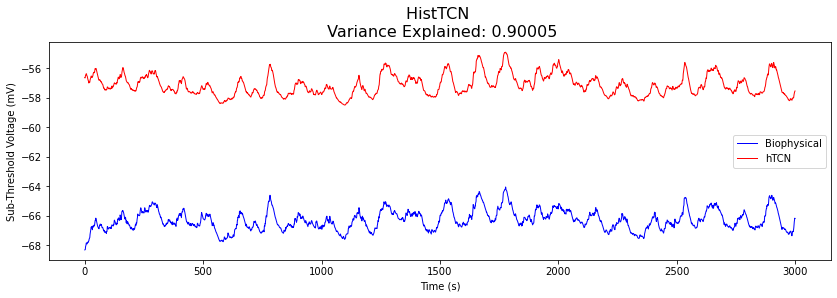

In [8]:
plt.figure(figsize = (14,4))
plt.plot(test_V_ref[5000:8000], label="Biophysical", c="blue", linewidth=1)
plt.plot(test_V_final[5000:8000]-55,label="hTCN", c="red", linewidth=1)
print(np.corrcoef(test_V_ref, test_V_final)[0][1])


test_score = metrics.explained_variance_score(y_true=test_V_ref,
                                                      y_pred=test_V_final,
                                                      multioutput='uniform_average')

plt.title("HistTCN \n Variance Explained: " + str(round(test_score, 5)), fontsize = 16)
#plt.xticks(np.arange(0,8001,1000),[0,1,2,3,4,5,6,7,8])
#plt.xticks(np.arange(0,4001,1000),[0,1,2,3,4])
plt.xlabel("Time (s)")
plt.ylabel("Sub-Threshold Voltage (mV)")
plt.legend()
#plt.show()


#plt.savefig("/media/hdd01/sklee/tcn/HistTCN_L23_sub5_b4.png", dpi=150, bbox_inches='tight')#

In [9]:
#np.save("/media/hdd01/sklee/tcn/histtcn_CA1_sub6_test.npy", test_V_final)

In [10]:
hist_weights = model.conv_hist_weights
hist_bases = model.conv_hist_bases
hist_prod = torch.matmul(hist_weights, hist_bases).cpu().detach().numpy()
for i in range(hist_prod.shape[0]):
    hist_prod[i] /= np.max(np.abs(hist_prod[i]))
    hist_prod[i] = np.flip(hist_prod[i])

In [11]:
#np.save("/media/hdd01/sklee/tcn/histtcn_CA1_sub6_hist_kern.npy", hist_prod)

In [13]:
e_weights = model.conv1_e_weights
e_bases = model.conv1_e_bases
e_prod = torch.matmul(e_weights, e_bases).cpu().detach().numpy()

i_weights = model.conv1_i_weights
i_bases = model.conv1_i_bases
i_prod = torch.matmul(i_weights, i_bases).cpu().detach().numpy()

for i in range(e_prod.shape[0]):
    e_prod[i] /= np.max(np.abs(e_prod[i]))
    i_prod[i] /= np.max(np.abs(i_prod[i]))
    e_prod[i] = np.flip(e_prod[i])
    i_prod[i] = np.flip(i_prod[i])

In [17]:
#np.save("/media/hdd01/sklee/tcn/histtcn_CA1_sub6_e_kern.npy", e_prod)
#np.save("/media/hdd01/sklee/tcn/histtcn_CA1_sub6_i_kern.npy", i_prod)